#Turma 15IA - Grupo 3

##INTEGRANTES

- André Ricardo Koeppl RM 337234

- Claudio Baraza Lopes RM 337620

- Tiago Cundari RM 339135

- Marcus Vinicius Galdino RM 338429


# Configurações

Imports de Pacotes

In [ ]:
#pip install watson-developer-cloud==2.0.0 

In [ ]:
#pip install ibm-watson

In [ ]:
#pip install azure.cognitiveservices.vision.face

In [216]:
from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode
import json
import os
import requests
import pandas as pd

#Visual Recognition
from ibm_watson import VisualRecognitionV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

#Azure Vision
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from PIL import Image as IMG, ImageDraw


Funções úteis

In [217]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [218]:
def get_visual_recognition(image, classifier):
  mykey = {
    "key": "",
    "url": ""
  }
   # (your url)
  data = requests.get('https://raw.githubusercontent.com/MBAThreeRocks/plataformas-cognitivas-docker/master/keys/keys.json') .json()
  with open('keys.json', 'w') as f:
    json.dump(data, f)
  if os.path.exists('keys.json'):
    with open('keys.json') as json_file:
      mykey = json.load(json_file)

  authenticator = IAMAuthenticator(mykey["key"])
  visual_recognition = VisualRecognitionV3(version='2018-03-19', authenticator=authenticator)
  visual_recognition.set_service_url(mykey["url"])

  classifier_possible = ['default', 'food', 'explicit']
  classifier_id = classifier_possible[classifier]  
  with open(image, 'rb') as one_image_file:
    classes1 = visual_recognition.classify(images_file=one_image_file,
                                           images_filename="temp",
                                           threshold=0.3,
                                           classifier_ids=classifier_id).get_result()

  #print(json.dump(classes1, open("out.json","w")))
  
  return classes1

def get_list_classes(data):
  list_classes = []
  for image in data['images']:
    for classifier in image['classifiers']:
      for classe in classifier['classes']:
        print(classe)
        list_classes.append(classe)
  return list_classes

In [219]:
def getRectangle(faceDictionary):
  """
  Função para criar um retângulo a partir de uma face identificada pelo Azure Face Detection
  :param faceDictionary:
  :return:
  """
  rect = faceDictionary.face_rectangle
  left = rect.left
  top = rect.top
  right = left + rect.width
  bottom = top + rect.height

  return ((left, top), (right, bottom))


def drawCrossesOnFace(draw, faceLandmarks, size=2, color='white'):
    fl = faceLandmarks.as_dict()
    for l in fl.keys():
        x = fl[l]['x']
        y = fl[l]['y']
        draw.line(((x - size, y - size), (x + size, y + size)), fill=color)
        draw.line(((x - size, y + size), (x + size, y - size)), fill=color)
    pass


def get_atributes_and_landmarks(image_name):
  data = requests.get('https://raw.githubusercontent.com/MBAThreeRocks/plataformas-cognitivas-docker/master/keys/azurekeys.json') .json()
  with open('azurekeys.json', 'w') as f:
    json.dump(data, f)
  with open("./azurekeys.json", 'r') as jsonfile:
      azurekeys = json.load(jsonfile)

  KEY = azurekeys["FacialDetection"]["KEY"] #Coloque aqui sua chave
  ENDPOINT = azurekeys["FacialDetection"]["ENDPOINT"]  #Coloque aqui seu endpoint (Ponto de Extremidade)
  face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

  return_face_attributes = ["age", "gender", "headPose", "smile", "hair", "accessories", "facialHair", "glasses", "emotion",  "noise", "occlusion", "blur", "makeup"]
  with open(image_name, 'r+b') as w:
    detected_faces = face_client.face.detect_with_stream(image=w, return_face_landmarks = True, return_face_attributes = return_face_attributes)
  
  faces_list = []
  for face in detected_faces:
    #print("**** Detected face id [{0}] on : {1}".format(face.face_id, face.face_rectangle))
    #print("Landmarks: ")
    #print(json.dumps(face.face_landmarks.as_dict(), indent=4) )
    #print("Atributes: ")
    #print(json.dumps(face.face_attributes.as_dict( ), indent=4) )
    faces_list.append({
        'landmarks':face.face_landmarks.as_dict(),
        'atributes':face.face_attributes.as_dict( )})

  return faces_list, detected_faces

def show_image_face(image_name, detected_faces):
  
  try:
    img = IMG.open(image_name)
    draw = ImageDraw.Draw(img)
    for face in detected_faces:
      draw.rectangle(getRectangle(face), outline='red')
      drawCrossesOnFace(draw, face.face_landmarks, size=2, color='white')
    display(img)
  except Exception as err:
    print(str(err))


In [220]:
def get_model_run(data):
  conteudo = data.to_json()
  my_server_ip = '34.72.32.211'
  my_server_port = '443'
  url = "http://{}:{}/predict".format(my_server_ip, my_server_port)
  headers = {'Content-Type': 'application/json'}
  response01 = requests.request("POST", url + "?model=modelo01", headers=headers, data=conteudo)
  print(response01)
  respostas01 = json.loads(response01.text.encode('utf8').decode())
  #print(respostas01)
  response02 = requests.request("POST", url + "?model=modelo02", headers=headers, data=conteudo)
  respostas02 = json.loads(response02.text.encode('utf8').decode())
  #print(respostas02)
  df_01 = pd.Series(respostas01['prediction'], index = data.index, name="modelo01")
  df_01B = pd.Series(respostas01['proba'], index = data.index, name="probamodelo01")
  df_02 = pd.Series(respostas02['prediction'], index = data.index, name="modelo02")
  return pd.DataFrame(data.loc[:,"nome"])\
    .merge(right= df_01, left_index=True, right_index=True)\
    .merge(df_01B, left_index=True, right_index=True)\
    .merge(df_02, left_index=True, right_index=True)

# Análise de crédito

1. Verifique se na imagem possui uma pessoa, utilizando a API "default" da IBM; Se não possuir, informar mensagem e não conceder o empréstimo.


2.  Verifique se a imagem apresenta conteúdo explícito , utilizando a API "explicit"da IBM; Se possuir, informar mensagem e não conceder o empréstimo.  


3. Verificar o gênero e a idade da pessoa utilizando a API de reconhecimento facial da Microsoft Azure; Se não for o mesmo gênero ou se a idade diferir em 5 anos (para mais ou para menos), informar mensagem e não conceder o empréstimo.


4. Exibir a imagem novamente no notebook com os pontos "fiduciais" da face da pessoa, obtidos pela API da Azure. (em uma aplicação corporativa, estes pontos ficam gravados para futuras autenticações)


5. Chamar a API de Machine Learning em um contêiner feito em Docker e que esteja rodando em uma máquina virtual no Google Cloud. Esta API deve usar os dados informados neste notebook e **automaticamente** vetar ou conceder o empréstimo.


ATENÇÃO PARA O BULLET 5: É necessário chamar tanto um modelo que possua a variável ETNIA quanto um modelo que não possui esta variável, assim como fizemos em aula!!!


6. Gravar um vídeo "operando" o notebook e simulando a avaliação com concessão ou reprovação do crédito.


7. Submeter o Notebook e o vídeo da plataforma da FIAP, se o vídeo ficar muito grande, submeter ao Youtube (pode ser privado) e anexar o Link.

---  
(Dica: Você pode usar este vídeo para divulgar seu trabalho como Engenheiro de ML)


# Simulação de uma aplicação para empréstimo de crédito

- IBM Watson Visual Recognition 
- Azure Computer Vision
- Google Cloud VM - Modelos da aplicação

# Informações do cliente

In [221]:
#@title Preencha aqui com as informações do cliente requisitante

#@markdown Informe todos os campos a seguir:
nome = "Marcus Vinicius Galdino Medeiros" #@param {type:"string"}

renda = 7000.00 #@param {type:"number"}
idade = 20 #@param {type:"slider", min:18, max:100, step:1}
etnia = "Etnia02"  #@param ["Selecionar etnia", "Etnia01", "Etnia02"]
genero = "Masculino" #@param ["Masculino", "Feminino"]
casa_propria = "Não" #@param ["Selecionar", "Sim", "Não"]
outras_rendas = "Sim" #@param ["Selecionar", "Sim", "Não"]
estado_civil = "Estado01" #@param ["Selecionar", "Estado01", "Estado02"]
escolaridade = 3 #@param {type:"slider", min:0, max:3, step:1}

#@markdown ---


<IPython.core.display.Javascript object>

Saved to photo.jpg


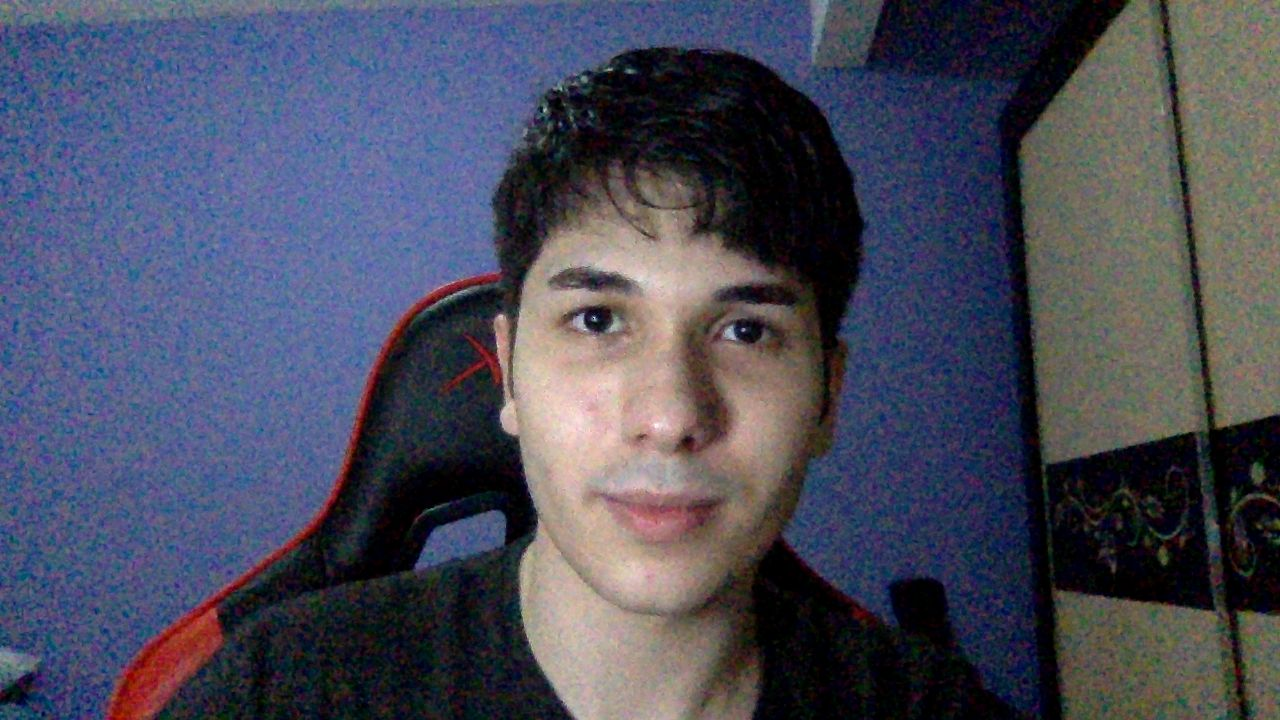

In [222]:
#@title Tire uma foto do cliente requerente (ou tire uma foto sua mesmo)
filename = ''
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Formatação dos dados

In [223]:
etnia = 'Etnia01' == etnia if 0 else 1
genero = 'Masculino' != genero if 0 else 1
casa_propria = 'Sim' != casa_propria if 0 else 1
outras_rendas = 'Sim' != outras_rendas if 0 else 1
estado_civil = 'Estado01' == estado_civil if 0 else 1
data = pd.DataFrame({'nome': [nome], 'renda': [renda], 'idade': [idade], 'etnia': [etnia], 'sexo': [genero], 
                     'casapropria': [casa_propria], 'outrasrendas': [outras_rendas], 'estadocivil': [estado_civil], 'escolaridade': [escolaridade],})
data.head()


,nome,renda,idade,etnia,sexo,casapropria,outrasrendas,estadocivil,escolaridade
0,Marcus Vinicius Galdino Medeiros,7000.0,20,1,1,1,1,1,3


## Verificação do Visual Recognition da IBM
Verificando se reconhece uma pessoa

In [224]:
default_result = get_visual_recognition(filename, 0)
default_result

{'custom_classes': 0,
 'images': [{'classifiers': [{'classes': [{'class': 'person', 'score': 0.634},
      {'class': 'people', 'score': 0.504, 'type_hierarchy': '/person/people'},
      {'class': 'pompadour hairstyle',
       'score': 0.5,
       'type_hierarchy': '/person/pompadour hairstyle'},
      {'class': 'purple color', 'score': 0.44},
      {'class': 'chestnut red color', 'score': 0.359}],
     'classifier_id': 'default',
     'name': 'default'}],
   'image': 'temp'}],
 'images_processed': 1}

In [225]:
list_classes = get_list_classes(default_result)

{'class': 'person', 'score': 0.634}
{'class': 'people', 'score': 0.504, 'type_hierarchy': '/person/people'}
{'class': 'pompadour hairstyle', 'score': 0.5, 'type_hierarchy': '/person/pompadour hairstyle'}
{'class': 'purple color', 'score': 0.44}
{'class': 'chestnut red color', 'score': 0.359}


In [226]:
person = False
for classe in list_classes:
  if classe['class'] == 'person' and classe['score'] > 0.4 :
    person = True
if person :
  print('É uma pessoa, valido')
else: 
  print('Não é uma pessoa, invalido')

É uma pessoa, valido


In [227]:
explicit_result = get_visual_recognition(filename, 2)
explicit_result

{'custom_classes': 0,
 'images': [{'classifiers': [{'classes': [{'class': 'not explicit',
       'score': 0.984}],
     'classifier_id': 'explicit',
     'name': 'explicit'}],
   'image': 'temp'}],
 'images_processed': 1}

In [228]:
list_classes = get_list_classes(explicit_result)

{'class': 'not explicit', 'score': 0.984}


In [229]:
not_explicit = False
for classes in list_classes: 
  if classes['class'] == 'not explicit':
    not_explicit = True
if not_explicit :
  print('Não é explicito, valido')
else: 
  print('É explicito, invalido')

Não é explicito, valido


## Azure Computing Vision: reconhecimento dos atributos Facial

In [230]:
faces_list, detected_faces = get_atributes_and_landmarks(filename)
faces_list

[{'atributes': {'accessories': [],
   'age': 24.0,
   'blur': {'blur_level': 'Low', 'value': 0.23},
   'emotion': {'anger': 0.0,
    'contempt': 0.001,
    'disgust': 0.0,
    'fear': 0.0,
    'happiness': 0.041,
    'neutral': 0.958,
    'sadness': 0.0,
    'surprise': 0.0},
   'facial_hair': {'beard': 0.1, 'moustache': 0.1, 'sideburns': 0.1},
   'gender': 'male',
   'glasses': 'noGlasses',
   'hair': {'bald': 0.05,
    'hair_color': [{'color': 'black', 'confidence': 1.0},
     {'color': 'gray', 'confidence': 0.88},
     {'color': 'other', 'confidence': 0.57},
     {'color': 'brown', 'confidence': 0.44},
     {'color': 'blond', 'confidence': 0.05},
     {'color': 'red', 'confidence': 0.01},
     {'color': 'white', 'confidence': 0.0}],
    'invisible': False},
   'head_pose': {'pitch': -7.3, 'roll': 5.7, 'yaw': 5.0},
   'makeup': {'eye_makeup': True, 'lip_makeup': True},
   'noise': {'noise_level': 'Medium', 'value': 0.35},
   'occlusion': {'eye_occluded': False,
    'forehead_occluded

In [231]:
if len(faces_list) == 1:
  print('Validado foto com uma unica pessoa')

Validado foto com uma unica pessoa


In [232]:
valid_idade = False
valid_sexo = False
for face in faces_list:
  atributes = face['atributes']
  #print(atributes)
  print(atributes['age'])
  print(atributes['gender'])
  idade = data.idade.values[0]
  sexo = data.sexo.values[0]
  if idade <= (atributes['age'] + 5) and idade >= (atributes['age'] - 5):
    valid_idade = True 
  if atributes['gender'] == 'male' and sexo == 1:
    valid_sexo = True
  if atributes['gender'] == 'female' and sexo == 0:
    valid_sexo = True

24.0
male


## Validar a idade e o gênero

In [233]:
if valid_idade:
  print('Idade é valido')
else:
  print("Idade invalida")

if valid_sexo:
  print('O genero da pessoa é o mesmo do da foto, valido')
else:
  print("Reconheceu generos diferente com o da foto, invalido")

Idade é valido
O genero da pessoa é o mesmo do da foto, valido


## Exibição dos pontos "fiduciais" da face da pessoa

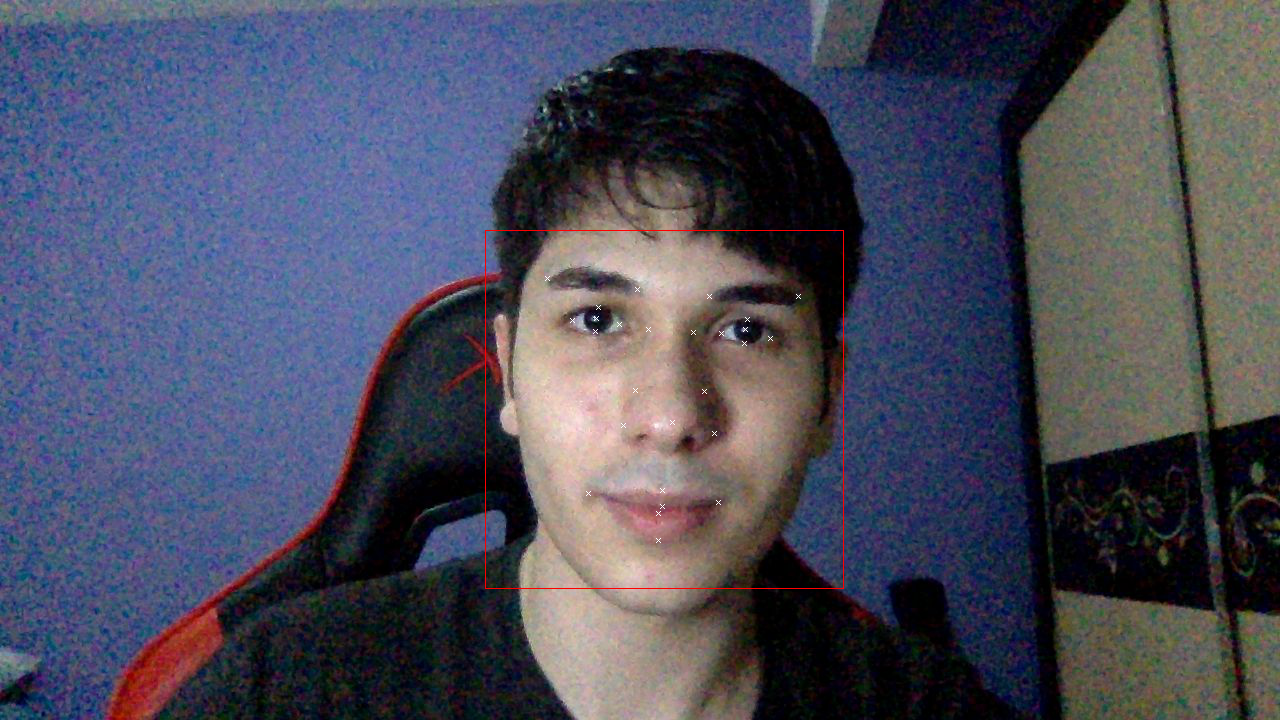

In [234]:
show_image_face(filename, detected_faces)

## Treinamento dos modelos

Foram criados dois modelos e exportados para serem usados do modelo de api docker.

https://github.com/MBAThreeRocks/plataformas-cognitivas-docker/blob/master/Modelo_01_Bayes.ipynb

https://github.com/MBAThreeRocks/plataformas-cognitivas-docker/blob/master/Modelo_02_SVC.ipynb

## Rodando os modelos com os dados coletados

Aqui temos dois modelos que usam um a etnia e o outro não com o resultado dos dois combinados vamos verificar se vai conceder o crédito

In [235]:
#Rodando o modelo
result = get_model_run(data)
result.head()

<Response [200]>


,nome,modelo01,probamodelo01,modelo02
0,Marcus Vinicius Galdino Medeiros,0,"[0.9987229144015168, 0.0012770855984831936]",-0.002889


## Resultado Final do Emprestimo

In [236]:
status_credit = False
if result['modelo01'].values[0] == 0:
  if result['modelo02'].values[0] < 0.5 or result['modelo02'].values[0] > 0.5:
    status_credit = True
  
if status_credit:
  print('Emprestimo concedido')
else: 
  print('Emprestimo negado')

Emprestimo concedido
